### Load Dataset

In [1]:
data.raw = read.csv("final_cleaned_data.csv")
data.future = read.csv("final_data_unknown_quality.csv")

In [2]:
tail(data.raw)

,Year,Month,Day,MaxTemp
47080,1983,11,25,17.0
47081,1983,11,26,22.6
47082,1983,11,27,24.5
47083,1983,11,28,25.6
47084,1983,11,29,27.5
47085,1983,11,30,18.5


In [3]:
# These values should be treated as constants
NROW = nrow(data.raw)
NCOL = ncol(data.raw)

FIRST_DATE = "1867-12-29"
FORECAST_FIRST_DATE = "1983-12-01"

In [4]:
NROW

[1] 42340

In [5]:
YEARS = unique(data.raw$Year)

### Visualizing raw time series (cleaned)

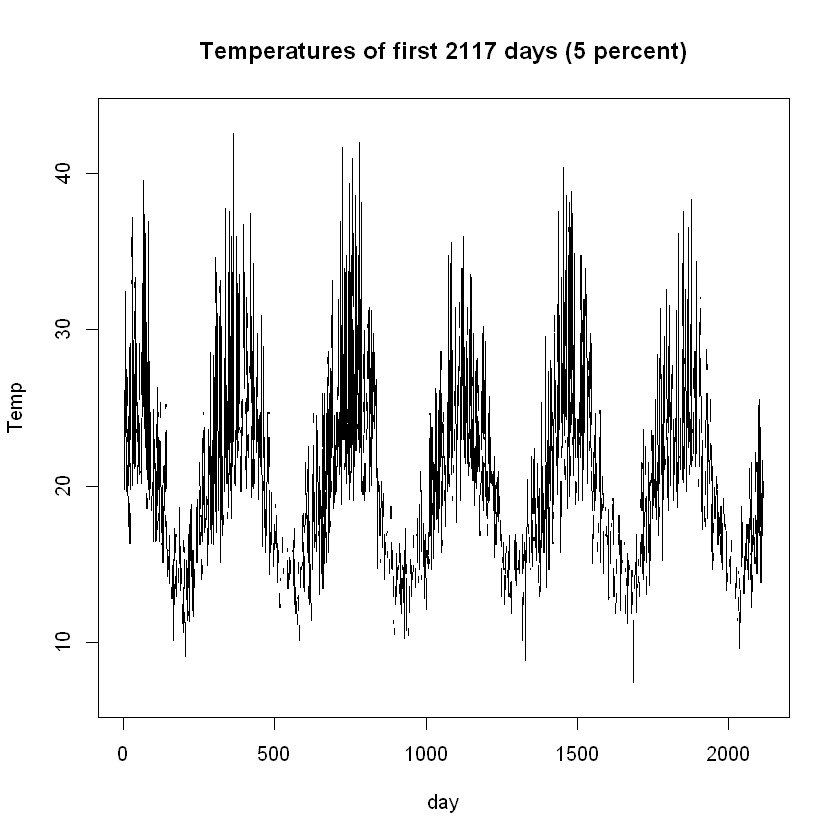

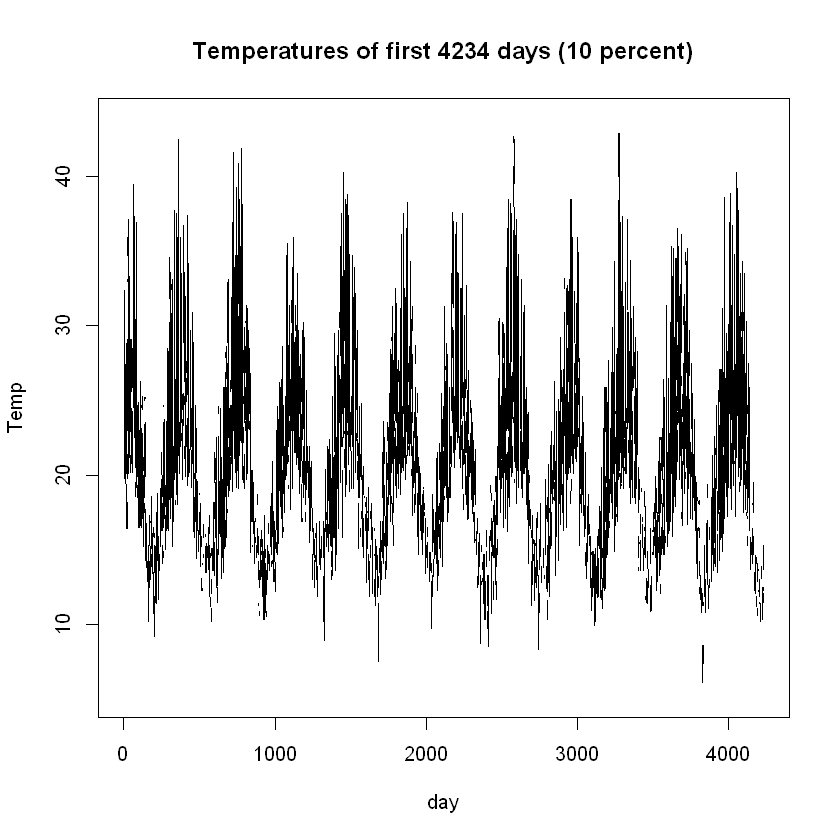

In [6]:
# jpeg(filename="plots/raw-ts/first5percent.jpg")
plot(data.raw$MaxTemp[1:as.integer(NROW*0.05)], type = 'c', main = 'Temperatures of first 2117 days (5 percent)', ylab = 'Temp', xlab = 'day')
# dev.off()

# jpeg(filename="plots/raw-ts/first10percent.jpg")
plot(data.raw$MaxTemp[1:as.integer(NROW*0.1)], type = 'c', main = 'Temperatures of first 4234 days (10 percent)', ylab = 'Temp', xlab = 'day')
# dev.off()

In [36]:
# Visualize yearly
library(stringr)


# Plotting parameters
frequency = 5
i = 2

# Plot and save
while (i + frequency - 1 <= length(YEARS)){
    
    string = str_c('/Years-', toString(YEARS[i]), '-to-', toString(YEARS[i + frequency - 1]))
    jpeg(filename= str_c('plots/raw-ts/yearly/freq', toString(frequency), string, '.jpg'))
    
    par(mfrow=c(frequency, 1), oma = c(2, 2, 0, 0), mar = c(0.6, 0.6, 0.6, 0.6), mgp = c(2, 1, 0)) 
    
    for (j in c(0 : (frequency - 1))){
        df = data.raw[c(which(data.raw$Year == YEARS[i+j])), ]
        plot(df$MaxTemp, type = 'l', ylim = c(min(df$MaxTemp) - 5, max(df$MaxTemp) + 5))
    }
    
    title(ylab = 'Temperature', xlab = 'Day', outer = TRUE, line = 1)
    
    dev.off()
    i = i + frequency
}

### Filtering out seasonal component (using band filter)

In [7]:
# Oscillations to be subtracted
seasonal.annual = spectral::filter.fft(data.raw$MaxTemp, x = NULL, fc = 0.002725, BW = 0.00105, n = 1)
seasonal.biannual = spectral::filter.fft(data.raw$MaxTemp, x = NULL, fc = 0.00545, BW = 0.0002, n = 1)
# seasonal.biannual = 0

# This is for recovering original data
imaginary_residuals = Im(data.raw$MaxTemp - seasonal.annual - seasonal.biannual)

# This is for further processing
data.raw.filtered = data.frame(data.raw)
data.raw.filtered$MaxTemp = Re(data.raw$MaxTemp - seasonal.annual - seasonal.biannual)

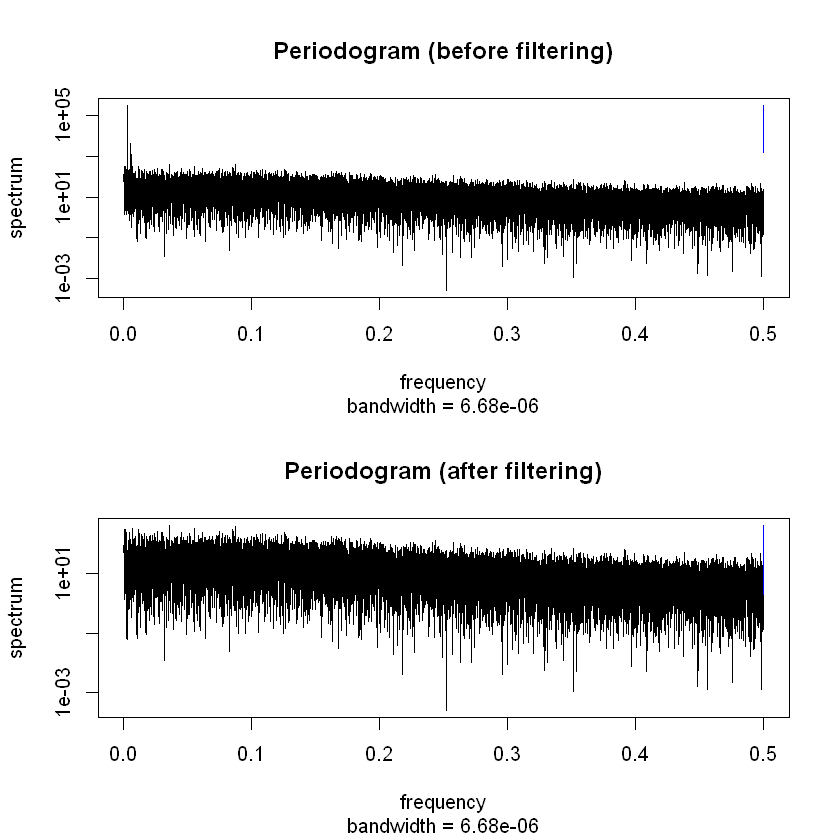

In [8]:
# Visualize periodogram (before vs after)
save_plot = 0

if (save_plot){
    jpeg(filename="plots/filtering/Periodogram-before-and-after.jpg")
    par(mfrow=c(2,1)) 
    spectrum(data.raw$MaxTemp, main = 'Periodogram (before filtering)')
    spectrum(data.raw.filtered$MaxTemp, main = 'Periodogram (after filtering)')
    dev.off()
} else {
    par(mfrow=c(2,1)) 
    spectrum(data.raw$MaxTemp, main = 'Periodogram (before filtering)')
    spectrum(data.raw.filtered$MaxTemp, main = 'Periodogram (after filtering)')    
}

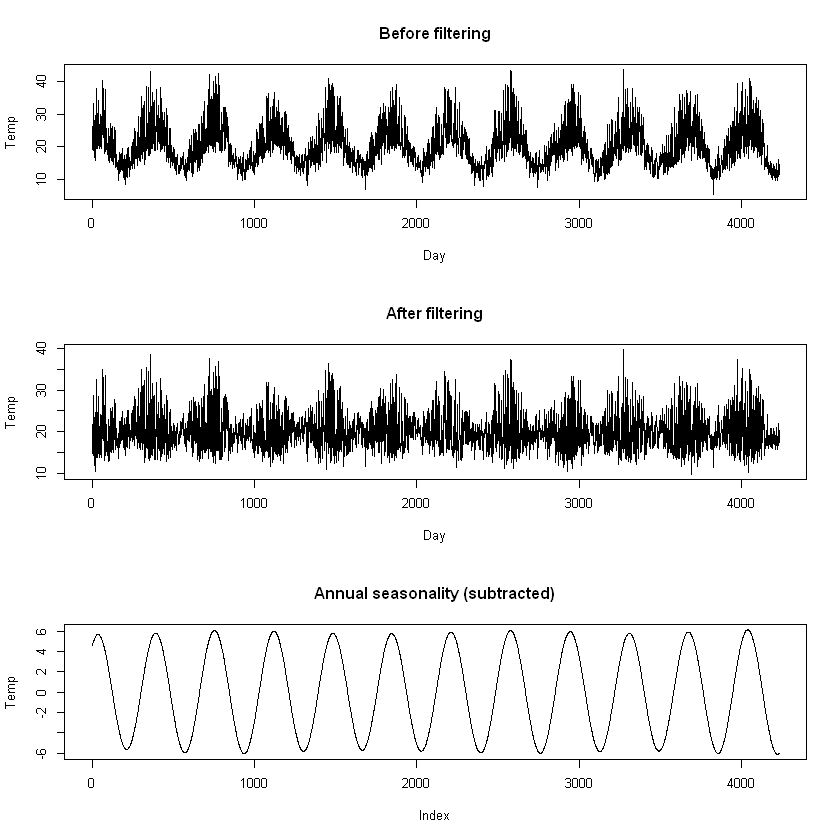

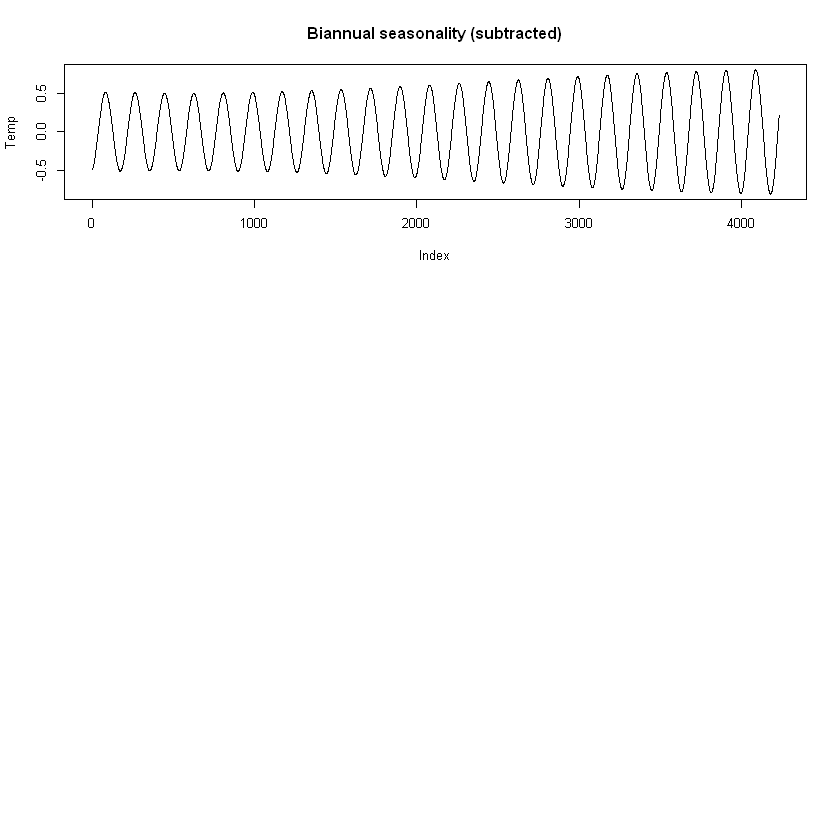

In [9]:
# Visualize time series(before vs after) and filtered components

save_plot = 0

if(save_plot){
    jpeg(filename="plots/filtering/TS-before-and-after.jpg")
    par(mfrow=c(2,1), oma = c(1, 1, 0, 0), mar = c(2, 2, 2, 2)) 
    plot(data.raw$MaxTemp[1:as.integer(NROW*0.1)], type = 'l', main = 'Before filtering', lwd = 0.01)
    plot(data.raw.filtered$MaxTemp[1:as.integer(NROW*0.1)], type = 'l', main = 'After filtering', lwd = 0.01)
    title(ylab = 'Temperature', xlab = 'Day (first 4234)', outer = TRUE, line = 0)
    dev.off()
    
    jpeg(filename="plots/filtering/Seasonality components (subtracted).jpg")
    par(mfrow=c(2,1), oma = c(1, 1, 0, 0), mar = c(2, 2, 2, 2)) 
    plot(Re(seasonal.annual[1:as.integer(NROW*0.6)]), type = 'l', main = 'Annual seasonality (subtracted)')
    plot(Re(seasonal.biannual[1:as.integer(NROW*0.6)]), type = 'l', main = 'Biannual seasonality (subtracted)')
    title(ylab = 'Temperature', xlab = 'Day (first 70 years)', outer = TRUE, line = 0)
    dev.off()
    
} else {
    par(mfrow=c(3,1)) 
    plot(data.raw$MaxTemp[1:as.integer(NROW*0.1)], type = 'l', ylab = 'Temp', xlab = 'Day', main = 'Before filtering')
    plot(data.raw.filtered$MaxTemp[1:as.integer(NROW*0.1)], type = 'l', ylab = 'Temp', xlab = 'Day', main = 'After filtering')
    plot(Re(seasonal.annual[1:as.integer(NROW*0.1)]), type = 'l', ylab = 'Temp', main = 'Annual seasonality (subtracted)')
    plot(Re(seasonal.biannual[1:as.integer(NROW*0.1)]), type = 'l', ylab = 'Temp', main = 'Biannual seasonality (subtracted)')   
}



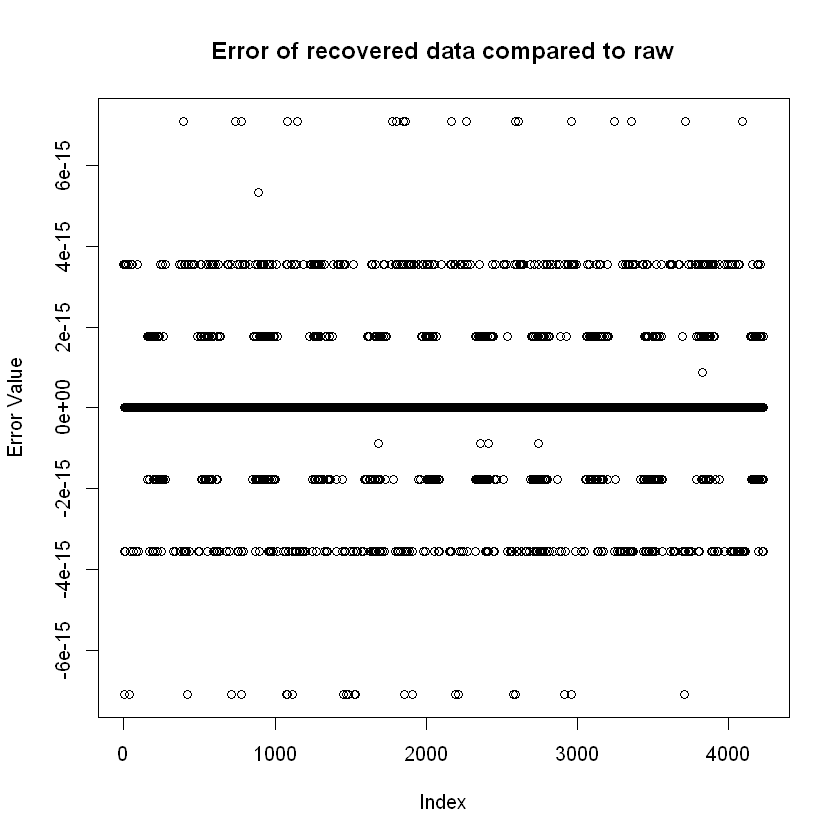

In [54]:
# Simulate procedure of recovering raw data from subtracted components
recovered = complex(imaginary = imaginary_residuals, real = data.raw.filtered$MaxTemp) + seasonal.annual + seasonal.biannual
plot((Re(recovered) - data.raw$MaxTemp)[1:as.integer(NROW*0.1)], ylab = 'Error Value', main = 'Error of recovered data compared to raw')

### Normalize data to obtain data with constant variance (over time)

In [8]:
data.raw.filtered.normalized = data.frame(data.raw.filtered)

# Find average and variance of each day of the year
grouped.daily.var = aggregate(MaxTemp ~ Month*Day, data.raw.filtered.normalized, FUN = var)
grouped.daily.var = grouped.daily.var[order(grouped.daily.var$Month, grouped.daily.var$Day), ]
grouped.daily.avg = aggregate(MaxTemp ~ Month*Day, data.raw.filtered.normalized, FUN = mean)
grouped.daily.avg = grouped.daily.avg[order(grouped.daily.avg$Month, grouped.daily.avg$Day), ]

In [63]:
# Visualize grouped variance and average
save_plot = 1

jpeg(
  "plots/normalization/Variance-and-Mean-by-Day-of-Year.jpg",
  width     = 2.80,
  height    = 1.40,
  units     = "in",
  res       = 400,
  pointsize = 4
)


if(save_plot){
#     jpeg(filename="plots/normalization/Variance-and-Mean-by-Day-of-Year.jpg")
    par(mfrow=c(1,2)) 
    plot(grouped.daily.var$MaxTemp, ylab = 'Variance', xlab = 'Day of year', main = 'Variance', lwd=0.5)
    plot(grouped.daily.avg$MaxTemp, ylab = 'Mean', xlab = 'Day of year', main = 'Mean', lwd=0.5)
    dev.off()
    
} else {
    par(mfrow=c(2,1)) 
    plot(grouped.daily.var$MaxTemp, ylab = 'Variance', xlab = 'Day of year', main = 'Variance')
    plot(grouped.daily.avg$MaxTemp, ylab = 'Mean', xlab = 'Day of year', main = 'Mean')
}

png 
  2

In [9]:
normalize = function(x, grouped_daily_var, grouped_daily_avg){
    for (row in c(1: nrow(x))){
        month = x[row, 2]
        day = x[row, 3]
        
        variance = grouped_daily_var[ which(grouped_daily_var$Month == month & grouped_daily_var$Day == day), ]$MaxTemp
        mean = grouped_daily_avg[ which(grouped_daily_avg$Month == month & grouped_daily_avg$Day == day), ]$MaxTemp
        
        x[row, 4] = (x[row, 4] - mean)/ sqrt(variance)
    }
    
    return(x)
}

reverse_normalize = function(x, grouped_daily_var, grouped_daily_avg, first_date){
    N = length(x)
    y = x
    date = as.Date(first_date) 
    
    for (i in c(0: (N-1))){
#         print(i)
        date = date + 1
        day = as.numeric(strftime(date, format = '%d'))
        month = as.numeric(strftime(date, format = '%m'))
        
        variance = grouped_daily_var[ which(grouped_daily_var$Month == month & grouped_daily_var$Day == day), ]$MaxTemp
        mean = grouped_daily_avg[ which(grouped_daily_avg$Month == month & grouped_daily_avg$Day == day), ]$MaxTemp
        
        y[i+1] = (x[i+1] * sqrt(variance)) + mean
    }
    return(y)
}


In [10]:
data.raw.filtered.normalized = normalize(data.raw.filtered.normalized, grouped.daily.var, grouped.daily.avg)

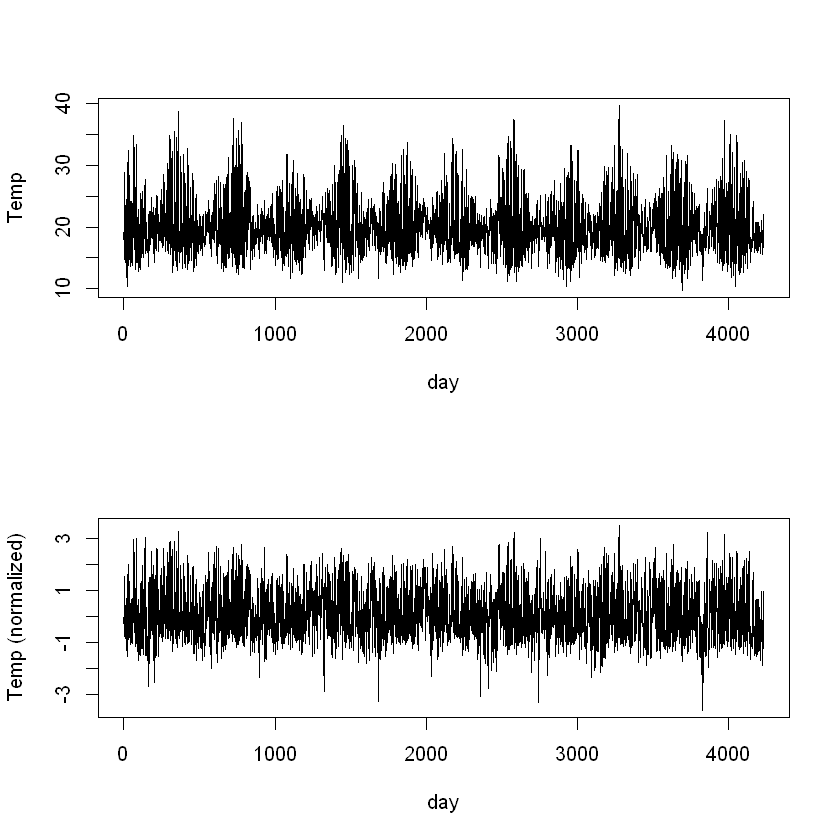

In [68]:
# Visualize normalized time series (before and after)
save_plot = 0

if(save_plot){
    jpeg(filename="plots/normalization/Normalization-before-and-after.jpg")
    par(mfrow=c(2,1)) 
    plot(data.raw.filtered$MaxTemp[1:as.integer(NROW*0.05)], ylab = 'Temperature', xlab = 'day', type = 'l')
    plot(data.raw.filtered.normalized$MaxTemp[1:as.integer(NROW*0.05)], ylab = 'Temperature (normalized)', xlab ='day', type = 'l')
    dev.off()
}else{
    par(mfrow=c(2,1)) 
    plot(data.raw.filtered$MaxTemp[1:as.integer(NROW*0.1)], ylab = 'Temp', xlab = 'day', type = 'l')
    plot(data.raw.filtered.normalized$MaxTemp[1:as.integer(NROW*0.1)], ylab = 'Temp (normalized)', xlab ='day', type = 'l')
}


In [61]:
# Visualize acf and pacf of normalized time series
save_plot = 1

jpeg(
  "plots/normalization/ACF-PACF-after-normalization.jpg",
  width     = 2.60,
  height    = 1.30,
  units     = "in",
  res       = 380,
  pointsize = 2,
)

if(save_plot){
#     jpeg(filename="plots/normalization/ACF-PACF-after-normalization.jpg")
    par(mfrow=c(1,2))
    acf(data.raw.filtered.normalized$MaxTemp, main = 'ACF of normalized series', cex.axis = 1.5, cex.lab = 1.5)
    pacf(data.raw.filtered.normalized$MaxTemp, main = 'PACF of normalized series', cex.axis = 1.5, cex.lab = 1.5)
    dev.off()
}else{
    par(mfrow=c(2,1))
    acf(data.raw.filtered.normalized$MaxTemp, main = 'Autocorrelation')
    pacf(data.raw.filtered.normalized$MaxTemp, main = 'Partial Autocorrelation')
}



png 
  2

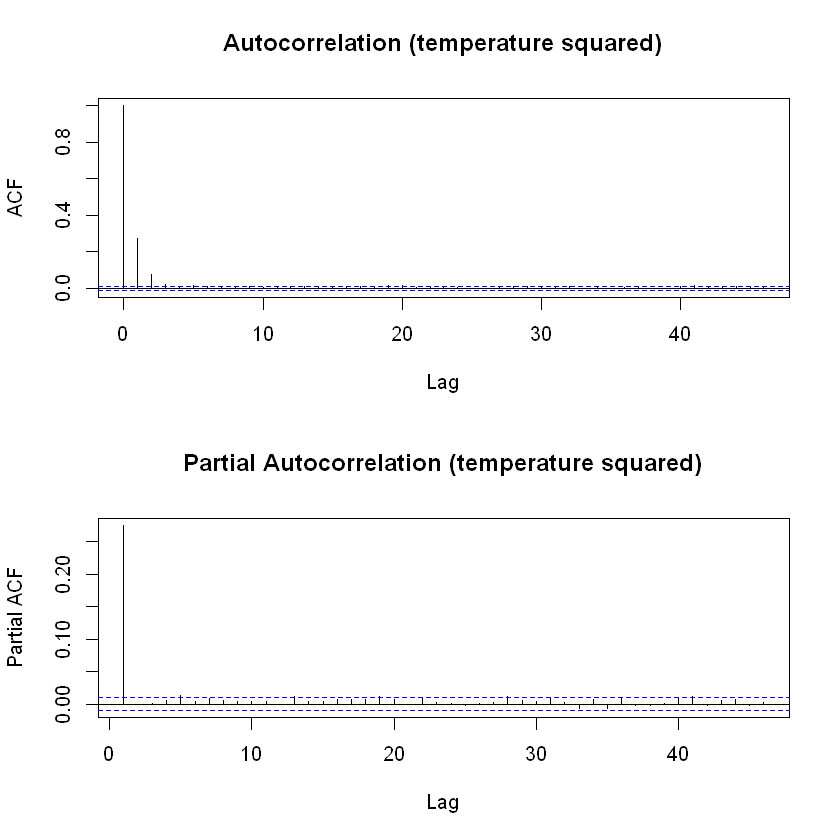

In [70]:
# Visualize acf and pacf of normalized time series
save_plot = 0

if(save_plot){
    jpeg(filename="plots/normalization/ACF-PACF-after-normalization-temperature-squared.jpg")
    par(mfrow=c(2,1))
    acf((data.raw.filtered.normalized$MaxTemp)^2, main = 'Autocorrelation (temperature squared)')
    pacf((data.raw.filtered.normalized$MaxTemp)^2, main = 'Partial Autocorrelation (temperature squared)')
    dev.off()
}else{
    par(mfrow=c(2,1))
    acf((data.raw.filtered.normalized$MaxTemp)^2, main = 'Autocorrelation (temperature squared)')
    pacf((data.raw.filtered.normalized$MaxTemp)^2, main = 'Partial Autocorrelation (temperature squared)')
}

### Stationarity Tests

In [49]:
library(LSTS)
# Use ljung box test to test for stationarity of normalized time series
save_plot = 1

jpeg(
  "plots/stationarity-test/LjungBox.jpg",
  width     = 2.80,
  height    = 1.40,
  units     = "in",
  res       = 400,
  pointsize = 4
)


if(save_plot){
#     jpeg(filename="plots/stationarity-test/LjungBox.png")
    par(mfrow=c(1,2))
#     Box.Ljung.Test(data.raw.filtered.normalized$MaxTemp, lag = 10)
    Box.Ljung.Test(data.raw.filtered.normalized$MaxTemp, lag = 20)
    Box.Ljung.Test(data.raw.filtered.normalized$MaxTemp, lag = 30)
#     Box.Ljung.Test(data.raw.filtered.normalized$MaxTemp, lag = 40)
    dev.off()
}else{
    par(mfrow=c(2,2))
    Box.Ljung.Test(data.raw.filtered.normalized$MaxTemp, lag = 10)
    Box.Ljung.Test(data.raw.filtered.normalized$MaxTemp, lag = 20)
    Box.Ljung.Test(data.raw.filtered.normalized$MaxTemp, lag = 30)
    Box.Ljung.Test(data.raw.filtered.normalized$MaxTemp, lag = 40)
}

png 
  2

In [19]:
# Augmented dickey fuller test to test for stationarity
library(aTSA)
adf.test(data.raw.filtered.normalized$MaxTemp, output = TRUE)


Attaching package: 'aTSA'

The following object is masked from 'package:LSTS':

    ts.diag

The following object is masked from 'package:graphics':

    identify



Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
      lag    ADF p.value
 [1,]   0 -124.4    0.01
 [2,]   1 -115.0    0.01
 [3,]   2  -99.1    0.01
 [4,]   3  -89.2    0.01
 [5,]   4  -81.4    0.01
 [6,]   5  -75.6    0.01
 [7,]   6  -70.2    0.01
 [8,]   7  -66.2    0.01
 [9,]   8  -63.0    0.01
[10,]   9  -60.1    0.01
[11,]  10  -57.1    0.01
[12,]  11  -54.9    0.01
[13,]  12  -52.5    0.01
[14,]  13  -50.8    0.01
[15,]  14  -48.8    0.01
[16,]  15  -47.5    0.01
Type 2: with drift no trend 
      lag    ADF p.value
 [1,]   0 -124.4    0.01
 [2,]   1 -115.0    0.01
 [3,]   2  -99.1    0.01
 [4,]   3  -89.2    0.01
 [5,]   4  -81.4    0.01
 [6,]   5  -75.6    0.01
 [7,]   6  -70.2    0.01
 [8,]   7  -66.2    0.01
 [9,]   8  -63.0    0.01
[10,]   9  -60.0    0.01
[11,]  10  -57.1    0.01
[12,]  11  -54.9    0.01
[13,]  12  -52.5    0.01
[14,]  13  -50.8    0.01
[15,]  14  -48.8    0.01
[16,]  15  -47.5    0.01
Type 3: with drift and trend 
      l

### ARMA - Fitting

In [11]:
ts = ts(data.raw.filtered.normalized$MaxTemp, frequency = 1)

In [12]:
library(forecast)

ar2 <- Arima(ts, order = c(2, 0, 0))
ar3 <- Arima(ts, order = c(3, 0, 0))
ar4 <- Arima(ts, order = c(4, 0, 0)) 
# ar1ma1 <- Arima(ts, order = c(1, 0, 1))
# ar2ma1 <- Arima(ts, order = c(2, 0, 1))
# ar3ma1 <- Arima(ts, order = c(3, 0, 1))

### Diagnostics (AR Models)
#### Summary

In [73]:
summary(ar2)
summary(ar3)
summary(ar4)

Series: ts 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
         ar1      ar2    mean
      0.5005  -0.0769  0.0000
s.e.  0.0048   0.0048  0.0074

sigma^2 estimated as 0.7727:  log likelihood=-54617.09
AIC=109242.2   AICc=109242.2   BIC=109276.8

Training set error measures:
                        ME      RMSE       MAE      MPE     MAPE      MASE
Training set -1.032538e-05 0.8789941 0.7055205 65.95593 227.9321 0.9050141
                    ACF1
Training set 0.001017318
Series: ts 
ARIMA(3,0,0) with non-zero mean 

Coefficients:
         ar1      ar2     ar3    mean
      0.5015  -0.0834  0.0131  0.0000
s.e.  0.0049   0.0054  0.0049  0.0075

sigma^2 estimated as 0.7726:  log likelihood=-54613.46
AIC=109236.9   AICc=109236.9   BIC=109280.2

Training set error measures:
                        ME      RMSE       MAE      MPE     MAPE      MASE
Training set -1.026012e-05 0.8789187 0.7056277 66.38314 227.7675 0.9051516
                     ACF1
Training set -3.19161e-07
Series: ts 
AR

#### Residuals

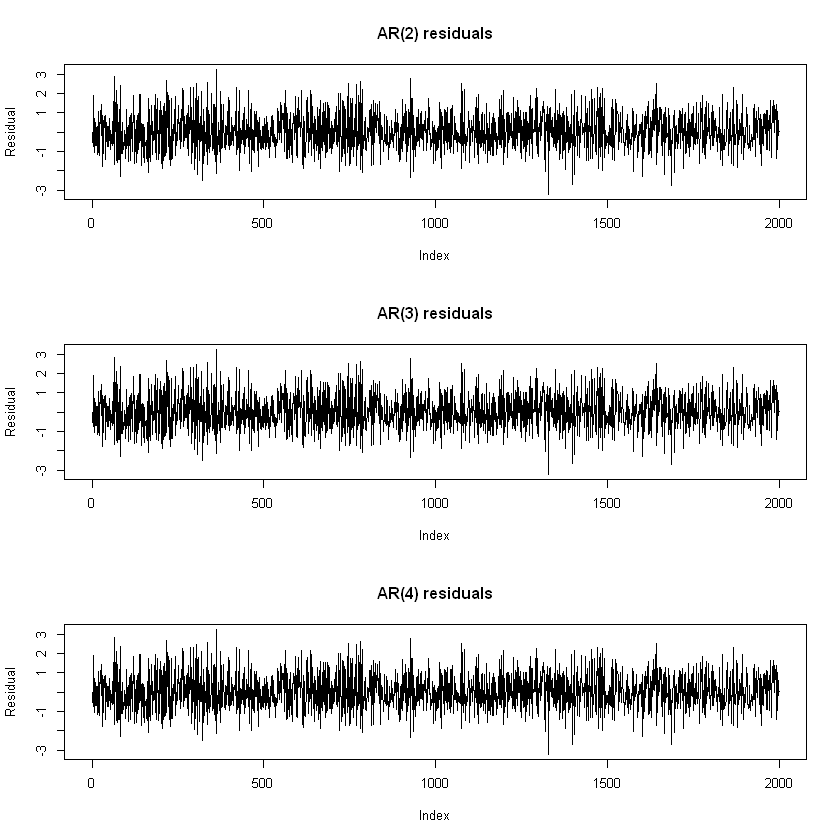

In [74]:
save_plot = 0

if(save_plot){
    jpeg(filename="plots/modeling/ARMA/ar2-ar3-ar4-residuals.jpg")
    par(mfrow=c(3,1))
    plot(ar2$residuals[1:2000], type = 'l', main = 'AR(2) residuals', ylab = 'Residual')
    plot(ar3$residuals[1:2000], type = 'l', main = 'AR(3) residuals', ylab = 'Residual')
    plot(ar4$residuals[1:2000], type = 'l', main = 'AR(4) residuals', ylab = 'Residual')
    dev.off()
}else{
    par(mfrow=c(3,1))
    plot(ar2$residuals[1:2000], type = 'l', main = 'AR(2) residuals', ylab = 'Residual')
    plot(ar3$residuals[1:2000], type = 'l', main = 'AR(3) residuals', ylab = 'Residual')
    plot(ar4$residuals[1:2000], type = 'l', main = 'AR(4) residuals', ylab = 'Residual')
}

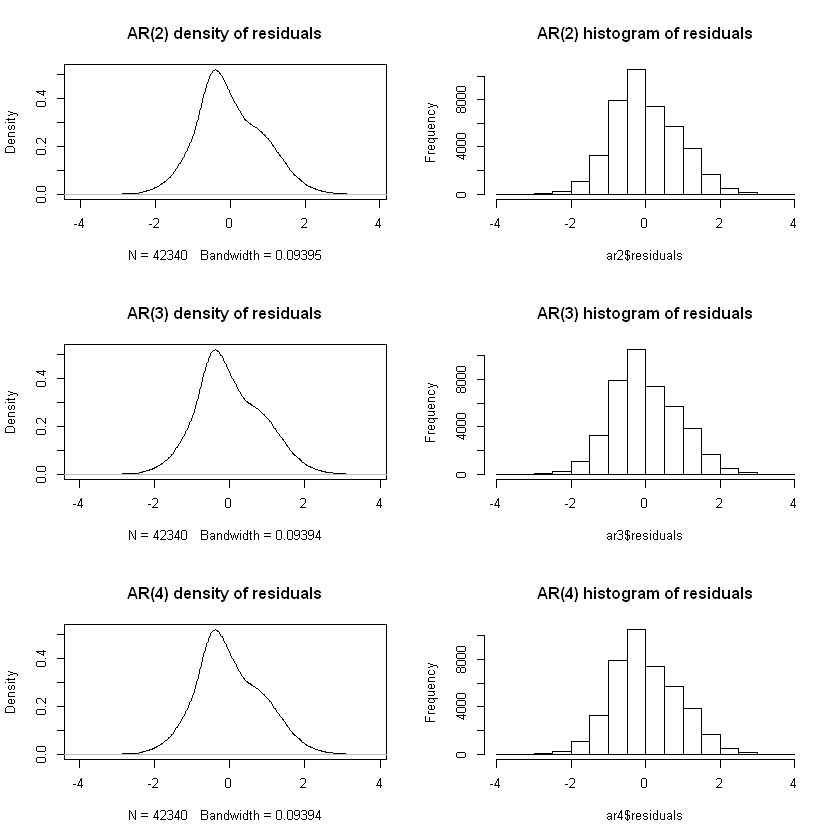

In [24]:
save_plot = 0

if(save_plot){
    jpeg(filename="plots/modeling/ARMA/ar2-ar3-ar4-residuals-density-histogram.jpg")
    par(mfrow=c(3,2))
    plot(density(ar2$residuals), main = 'AR(2) density of residuals')
    hist(ar2$residuals, main = 'AR(2) histogram of residuals')
    plot(density(ar3$residuals), main = 'AR(3) density of residuals')
    hist(ar3$residuals, main = 'AR(3) histogram of residuals')
    plot(density(ar4$residuals), main = 'AR(4) density of residuals')
    hist(ar4$residuals, main = 'AR(4) histogram of residuals')
    dev.off()
}else{
    par(mfrow=c(3,2))
    plot(density(ar2$residuals), main = 'AR(2) density of residuals')
    hist(ar2$residuals, main = 'AR(2) histogram of residuals')
    plot(density(ar3$residuals), main = 'AR(3) density of residuals')
    hist(ar3$residuals, main = 'AR(3) histogram of residuals')
    plot(density(ar4$residuals), main = 'AR(4) density of residuals')
    hist(ar4$residuals, main = 'AR(4) histogram of residuals')
}

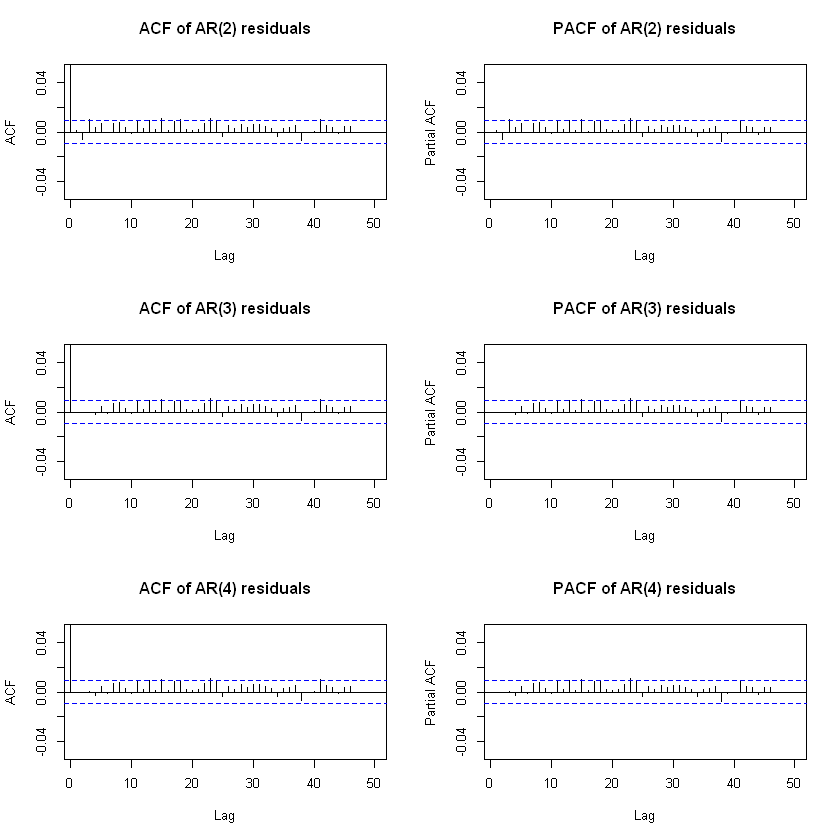

In [25]:
save_plot = 0

if(save_plot){
    jpeg(filename="plots/modeling/ARMA/ar2-ar3-ar4-residuals-ACF-PACF.jpg")
    par(mfrow=c(3,2))
    acf(ts(ar2$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(2) residuals')
    pacf(ts(ar2$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'PACF of AR(2) residuals')
    acf(ts(ar3$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(3) residuals')
    pacf(ts(ar3$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'PACF of AR(3) residuals')
    acf(ts(ar4$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(4) residuals')
    pacf(ts(ar4$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'PACF of AR(4) residuals')
    dev.off()
}else{
    par(mfrow=c(3,2))
    acf(ts(ar2$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(2) residuals')
    pacf(ts(ar2$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'PACF of AR(2) residuals')
    acf(ts(ar3$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(3) residuals')
    pacf(ts(ar3$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'PACF of AR(3) residuals')
    acf(ts(ar4$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(4) residuals')
    pacf(ts(ar4$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'PACF of AR(4) residuals')
}

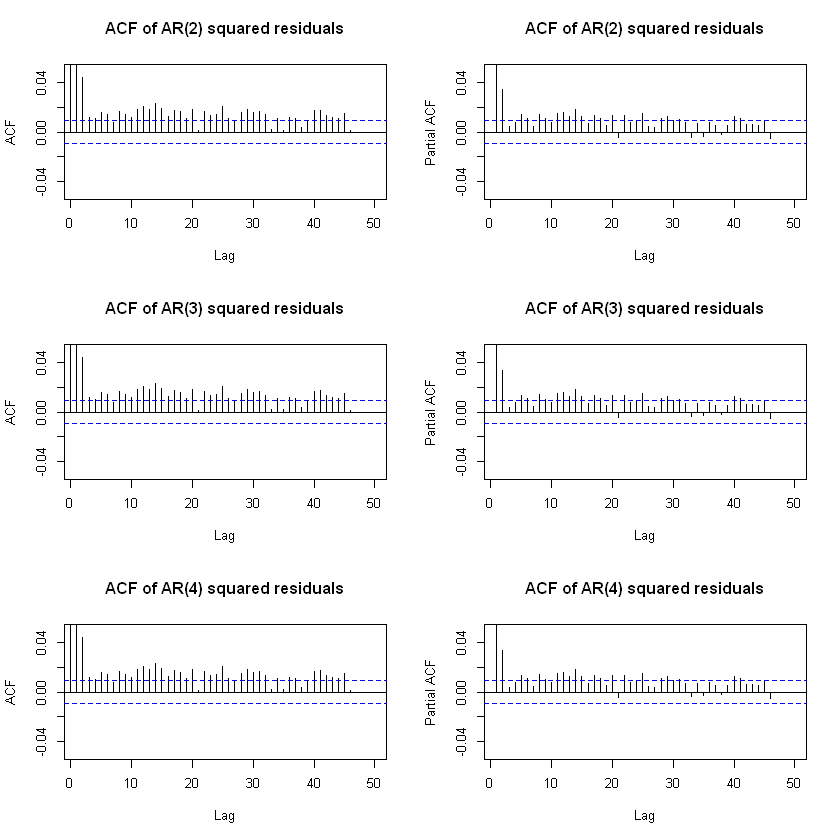

In [26]:
save_plot = 0

if(save_plot){
    jpeg(filename="plots/modeling/ARMA/ar2-ar3-ar4-squared-residuals-ACF-PACF.jpg")
    par(mfrow=c(3,2))
    acf(ts((ar2$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(2) squared residuals')
    pacf(ts((ar2$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(2) squared residuals')

    acf(ts((ar3$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(3) squared residuals')
    pacf(ts((ar3$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(3) squared residuals')

    acf(ts((ar4$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(4) squared residuals')
    pacf(ts((ar4$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(4) squared residuals')
    dev.off()
}else{
    par(mfrow=c(3,2))
    acf(ts((ar2$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(2) squared residuals')
    pacf(ts((ar2$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(2) squared residuals')

    acf(ts((ar3$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(3) squared residuals')
    pacf(ts((ar3$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(3) squared residuals')

    acf(ts((ar4$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(4) squared residuals')
    pacf(ts((ar4$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05), main = 'ACF of AR(4) squared residuals')
}

In [40]:
library(car)

save_plot = 1

if(save_plot){
    jpeg(filename="plots/modeling/ARMA/ar2-residuals-qqplot.jpg")
    qqPlot(ar2$residuals, cex = 0.3, main = 'QQPlot of AR(2) residuals', ylab = 'Emprical Quantiles', xlab = 'Theoretical Quantiles')
    dev.off()
    
    jpeg(filename="plots/modeling/ARMA/ar2-residuals-qqplot-zoomed.jpg")
    qqPlot(ar2$residuals, ylim = c(-2, 2), cex = 0.3, main = 'QQPlot of AR(2) residuals', ylab = 'Emprical Quantiles', xlab = 'Theoretical Quantiles')
    dev.off()
    
    jpeg(filename="plots/modeling/ARMA/ar3-residuals-qqplot.jpg")
    qqPlot(ar3$residuals, cex = 0.3, main = 'QQPlot of AR(3) residuals', ylab = 'Emprical Quantiles', xlab = 'Theoretical Quantiles')
    dev.off()
    
    jpeg(filename="plots/modeling/ARMA/ar4-residuals-qqplot.jpg")
    qqPlot(ar4$residuals, cex = 0.3, main = 'QQPlot of AR(4) residuals', ylab = 'Emprical Quantiles', xlab = 'Theoretical Quantiles')
    dev.off()
    
}else{
    qqPlot(ar2$residuals, ylim = c(-2, 2), cex = 0.3, main = 'QQPlot of AR(2) residuals')
    qqPlot(ar3$residuals, cex = 0.3, main = 'QQPlot of AR(3) residuals')
    qqPlot(ar4$residuals, cex = 0.3, main = 'QQPlot of AR(4) residuals')
}

png 
  2

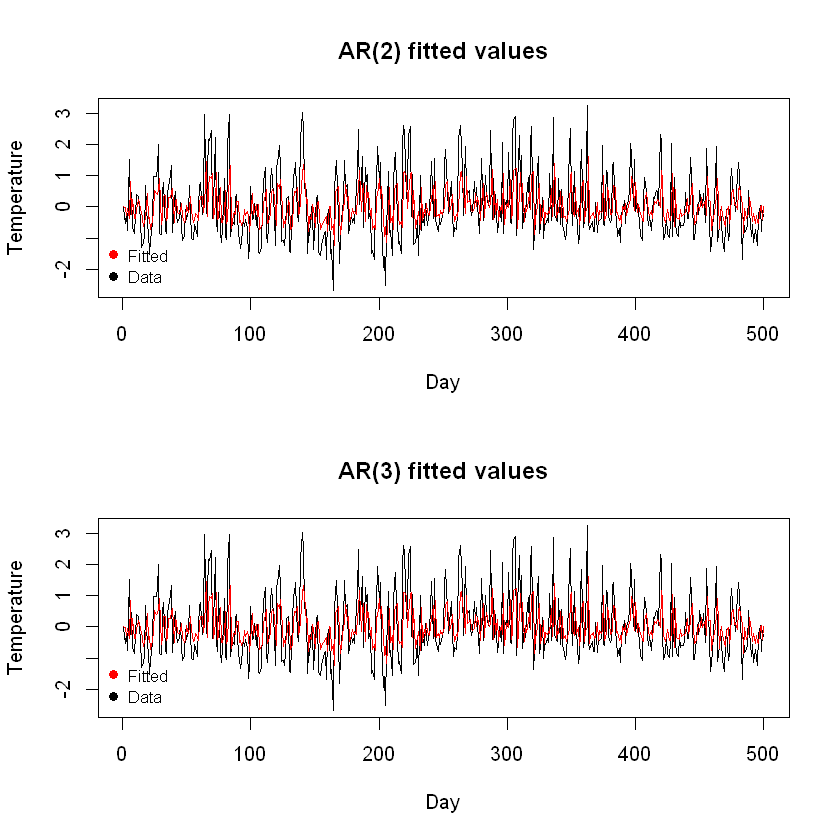

In [28]:
save_plot = 0

if(save_plot){
    jpeg(filename="plots/modeling/ARMA/ar2-ar3-fittedvalues.jpg")
    par(mfrow=c(2,1))
    plot(c(1:500), ar2$x[1:500], type = 'l', ylab = 'Temperature', xlab = 'Day', main = "AR(2) fitted values")
    lines(c(1:500), ar2$fitted[1:500], col = 'red', type = 'l')
    legend("bottomleft", legend = c("Fitted", "Data"), col = c("red", "black"), pch = c(19,19), bty = "n", pt.cex = 1, cex = 0.8, text.col = "black", horiz = F) 

    plot(c(1:500), ar3$x[1:500], type = 'l', ylab = 'Temperature', xlab = 'Day', main = "AR(3) fitted values")
    lines(c(1:500), ar3$fitted[1:500], col = 'red', type = 'l')
    legend("bottomleft", legend = c("Fitted", "Data"), col = c("red", "black"), pch = c(19,19), bty = "n", pt.cex = 1, cex = 0.8, text.col = "black", horiz = F) 
  
    dev.off()
}else{
    par(mfrow=c(2,1))
    plot(c(1:500), ar2$x[1:500], type = 'l', ylab = 'Temperature', xlab = 'Day', main = "AR(2) fitted values")
    lines(c(1:500), ar2$fitted[1:500], col = 'red', type = 'l')
    legend("bottomleft", legend = c("Fitted", "Data"), col = c("red", "black"), pch = c(19,19), bty = "n", pt.cex = 1, cex = 0.8, text.col = "black", horiz = F) 

    plot(c(1:500), ar3$x[1:500], type = 'l', ylab = 'Temperature', xlab = 'Day', main = "AR(3) fitted values")
    lines(c(1:500), ar3$fitted[1:500], col = 'red', type = 'l')
    legend("bottomleft", legend = c("Fitted", "Data"), col = c("red", "black"), pch = c(19,19), bty = "n", pt.cex = 1, cex = 0.8, text.col = "black", horiz = F) 
  
}

In [86]:
save_plot = 1

if(save_plot){
    jpeg(filename="plots/modeling/ARMA/ar2-fittedvalues-recovered-zoomed.jpg")
    
    par(mfrow=c(2,1))
    
    recovered_x = reverse_normalize(ar2$x, grouped.daily.var, grouped.daily.avg, FIRST_DATE)
    recovered_fitted = reverse_normalize(ar2$fitted, grouped.daily.var, grouped.daily.avg, FIRST_DATE)
    
    recovered_x = complex(imaginary = imaginary_residuals, real = recovered_x) + seasonal.annual + seasonal.biannual
    recovered_fitted = complex(imaginary = imaginary_residuals, real = recovered_fitted) + seasonal.annual + seasonal.biannual
    
    plot(c(1:200), Re(recovered_x)[1:200], type = 'l', ylab = 'Temperature', xlab = 'Day', main = "AR(2) fitted values, with seasonality")
    lines(c(1:200), Re(recovered_fitted)[1:200], col = 'red', type = 'l')
    legend("bottomleft", legend = c("Fitted", "Data"), col = c("red", "black"), pch = c(19,19), bty = "n", pt.cex = 1, cex = 0.8, text.col = "black", horiz = F) 
    
    plot(c(201:400), Re(recovered_x)[201:400], type = 'l', ylab = 'Temperature', xlab = 'Day', main = "AR(2) fitted values, with seasonality")
    lines(c(201:400), Re(recovered_fitted)[201:400], col = 'red', type = 'l')
    legend("bottomleft", legend = c("Fitted", "Data"), col = c("red", "black"), pch = c(19,19), bty = "n", pt.cex = 1, cex = 0.8, text.col = "black", horiz = F) 
    
    
    dev.off()
    
#     jpeg(filename="plots/modeling/ARMA/ar3-fittedvalues-recovered.jpg")
    
#     recovered_x = reverse_normalize(ar3$x, grouped.daily.var, grouped.daily.avg, FIRST_DATE)
#     recovered_fitted = reverse_normalize(ar3$fitted, grouped.daily.var, grouped.daily.avg, FIRST_DATE)
    
#     recovered_x = complex(imaginary = imaginary_residuals, real = recovered_x) + seasonal.annual + seasonal.biannual
#     recovered_fitted = complex(imaginary = imaginary_residuals, real = recovered_fitted) + seasonal.annual + seasonal.biannual
#     plot(c(1:600), Re(recovered_x)[1:600], type = 'l', ylab = 'Temperature', xlab = 'Day', main = "AR(3) fitted values, with seasonality")
#     lines(c(1:600), Re(recovered_fitted)[1:600], col = 'red', type = 'l')
#     legend("bottomleft", legend = c("Fitted", "Data"), col = c("red", "black"), pch = c(19,19), bty = "n", pt.cex = 1, cex = 0.8, text.col = "black", horiz = F) 
    
#     dev.off()
}else{
    par(mfrow=c(2,1))
    recovered_x = reverse_normalize(ar2$x, grouped.daily.var, grouped.daily.avg, FIRST_DATE)
    recovered_fitted = reverse_normalize(ar2$fitted, grouped.daily.var, grouped.daily.avg, FIRST_DATE)
    
    recovered_x = complex(imaginary = imaginary_residuals, real = recovered_x) + seasonal.annual + seasonal.biannual
    recovered_fitted = complex(imaginary = imaginary_residuals, real = recovered_fitted) + seasonal.annual + seasonal.biannual
    plot(c(1:600), Re(recovered_x)[1:600], type = 'l', ylab = 'Temperature', xlab = 'Day', main = "AR(2) fitted values, with seasonality")
    lines(c(1:600), Re(recovered_fitted)[1:600], col = 'red', type = 'l')
    legend("bottomleft", legend = c("Fitted", "Data"), col = c("red", "black"), pch = c(19,19), bty = "n", pt.cex = 1, cex = 0.8, text.col = "black", horiz = F) 
    
    recovered_x = reverse_normalize(ar3$x, grouped.daily.var, grouped.daily.avg, FIRST_DATE)
    recovered_fitted = reverse_normalize(ar3$fitted, grouped.daily.var, grouped.daily.avg, FIRST_DATE)
    
    recovered_x = complex(imaginary = imaginary_residuals, real = recovered_x) + seasonal.annual + seasonal.biannual
    recovered_fitted = complex(imaginary = imaginary_residuals, real = recovered_fitted) + seasonal.annual + seasonal.biannual
    plot(c(1:600), Re(recovered_x)[1:600], type = 'l', ylab = 'Temperature', xlab = 'Day', main = "AR(3) fitted values, with seasonality")
    lines(c(1:600), Re(recovered_fitted)[1:600], col = 'red', type = 'l')
    legend("bottomleft", legend = c("Fitted", "Data"), col = c("red", "black"), pch = c(19,19), bty = "n", pt.cex = 1, cex = 0.8, text.col = "black", horiz = F) 
  
}

png 
  2

### Forecasting (AR Models)

In [45]:
jpeg(filename="plots/modeling/ARMA/ar2-ar3-forecasting-without-seasonality.jpg")
par(mfrow=c(2,1))
ar2_forecast <- forecast(ar2, h=H)
plot(ar2_forecast, include = 50,  ylab = 'Temperature', xlab = 'Day', main = 'AR(2) forecasting')


ar3_forecast <- forecast(ar3, h=H)
plot(ar3_forecast, include = 50,  ylab = 'Temperature', xlab = 'Day', main = 'AR(3) forecasting')

dev.off()

png 
  2

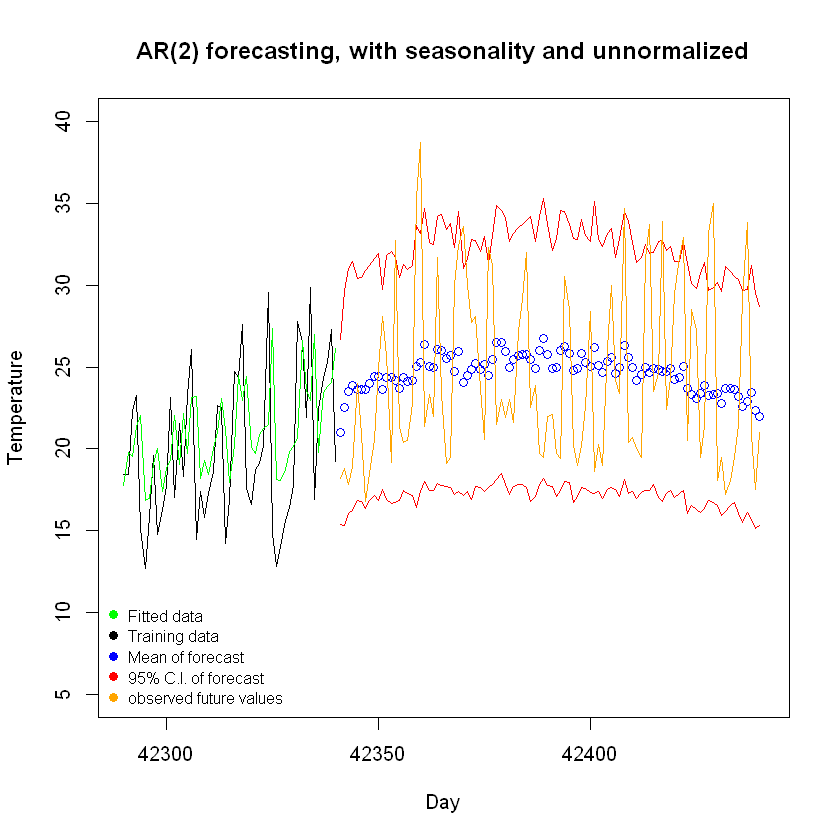

In [19]:
# jpeg(filename="plots/modeling/ARMA/ar3-forecasting-recovered-500days-with-obs.jpg")
H = 100

# par(mfrow=c(2,1))

ar2_forecast <- forecast(ar2, h=H)

recovered_x = reverse_normalize(ar2$x, grouped.daily.var, grouped.daily.avg, FIRST_DATE)
recovered_fitted = reverse_normalize(ar2$fitted, grouped.daily.var, grouped.daily.avg, FIRST_DATE)

recovered_x = complex(imaginary = imaginary_residuals, real = recovered_x) + seasonal.annual + seasonal.biannual
recovered_fitted = complex(imaginary = imaginary_residuals, real = recovered_fitted) + seasonal.annual + seasonal.biannual

ar2_recovered_forecast_mean = reverse_normalize(ar2_forecast$mean, grouped.daily.var, grouped.daily.avg, FORECAST_FIRST_DATE)
ar2_recovered_forecast_mean = complex(imaginary = imaginary_residuals[1:H], real = ar2_recovered_forecast_mean) + seasonal.annual[1:H] + seasonal.biannual[1:H]  

ar2_recovered_forecast_upper = reverse_normalize(ar2_forecast$upper, grouped.daily.var, grouped.daily.avg, FORECAST_FIRST_DATE)
ar2_recovered_forecast_upper = complex(imaginary = imaginary_residuals[1:H], real = ar2_recovered_forecast_upper) + seasonal.annual[1:H] + seasonal.biannual[1:H]  

ar2_recovered_forecast_lower = reverse_normalize(ar2_forecast$lower, grouped.daily.var, grouped.daily.avg, FORECAST_FIRST_DATE)
ar2_recovered_forecast_lower = complex(imaginary = imaginary_residuals[1:H], real = ar2_recovered_forecast_lower) + seasonal.annual[1:H] + seasonal.biannual[1:H]  

future_observed_x = data.future$MaxTemp[1:H]

plot(c(42290:42340), Re(recovered_x)[42290:42340], type = 'l', ylim = c(5, 40), xlim = c(42290,(42340 + H + 1)), ylab = 'Temperature', xlab = 'Day', main = 'AR(2) forecasting, with seasonality and unnormalized')
lines(c(42290:42340), Re(recovered_fitted)[42290:42340], col = 'green', type = 'l')
lines(c(42341:(42340 + H)), Re(ar2_recovered_forecast_mean)[1:H], col = 'blue', type = 'p')
lines(c(42341:(42340 + H)), Re(ar2_recovered_forecast_upper)[1:H], col = 'red', type = 'l')
lines(c(42341:(42340 + H)), Re(ar2_recovered_forecast_lower)[1:H], col = 'red', type = 'l')
lines(c(42341:(42340 + H)), future_observed_x, col = 'orange', type = 'l')

legend("bottomleft", legend = c("Fitted data", "Training data", "Mean of forecast", "95% C.I. of forecast", "observed future values"), 
       col = c("green", "black", "blue", "red", "orange"), 
       pch = c(19,19), bty = "n", pt.cex = 1, cex = 0.8, text.col = "black", horiz = F) 


# ar3
# ar3_forecast <- forecast(ar3, h=H)

# recovered_x = reverse_normalize(ar3$x, grouped.daily.var, grouped.daily.avg, FIRST_DATE)
# recovered_fitted = reverse_normalize(ar3$fitted, grouped.daily.var, grouped.daily.avg, FIRST_DATE)

# recovered_x = complex(imaginary = imaginary_residuals, real = recovered_x) + seasonal.annual + seasonal.biannual
# recovered_fitted = complex(imaginary = imaginary_residuals, real = recovered_fitted) + seasonal.annual + seasonal.biannual

# ar3_recovered_forecast_mean = reverse_normalize(ar3_forecast$mean, grouped.daily.var, grouped.daily.avg, FORECAST_FIRST_DATE)
# ar3_recovered_forecast_mean = complex(imaginary = imaginary_residuals[1:H], real = ar3_recovered_forecast_mean) + seasonal.annual[1:H] + seasonal.biannual[1:H]  

# ar3_recovered_forecast_upper = reverse_normalize(ar3_forecast$upper, grouped.daily.var, grouped.daily.avg, FORECAST_FIRST_DATE)
# ar3_recovered_forecast_upper = complex(imaginary = imaginary_residuals[1:H], real = ar3_recovered_forecast_upper) + seasonal.annual[1:H] + seasonal.biannual[1:H]  

# ar3_recovered_forecast_lower = reverse_normalize(ar3_forecast$lower, grouped.daily.var, grouped.daily.avg, FORECAST_FIRST_DATE)
# ar3_recovered_forecast_lower = complex(imaginary = imaginary_residuals[1:H], real = ar3_recovered_forecast_lower) + seasonal.annual[1:H] + seasonal.biannual[1:H]  

# plot(c(42290:42340), Re(recovered_x)[42290:42340], type = 'l', xlim = c(42290,(42340 + H + 1)), ylab = 'Temperature', xlab = 'Day', main = 'AR(3) forecasting, with seasonality and unnormalized')
# lines(c(42290:42340), Re(recovered_fitted)[42290:42340], col = 'green', type = 'l')
# lines(c(42341:(42340 + H)), Re(ar3_recovered_forecast_mean)[1:H], col = 'blue', type = 'l')
# lines(c(42341:(42340 + H)), Re(ar3_recovered_forecast_upper)[1:H], col = 'red', type = 'l')
# lines(c(42341:(42340 + H)), Re(ar3_recovered_forecast_lower)[1:H], col = 'red', type = 'l')

# legend("bottomleft", legend = c("Fitted", "Data"), col = c("red", "black"), pch = c(19,19), bty = "n", pt.cex = 1, cex = 0.8, text.col = "black", horiz = F) 

# dev.off()


In [20]:
k = 0
for (i in (1:length(future_observed_x))){
    upper = Re(ar2_recovered_forecast_upper[i])
    lower = Re(ar2_recovered_forecast_lower[i])
    x = future_observed_x[i]
    
    if (x <= upper & x >= lower){
        k = k + 1
    }
}

print(k/length(future_observed_x))

[1] 0.87


### ARMA-GARCH : Fitting

In [11]:
# install.packages("rugarch", repos = "http://cran.us.r-project.org") 
library(rugarch)

Loading required package: parallel

Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma



In [12]:
model = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 
    1)), mean.model = list(armaOrder = c(2, 0), include.mean = TRUE), distribution.model = "norm")
model

model1 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 
    0)), mean.model = list(armaOrder = c(2, 0), include.mean = TRUE), distribution.model = "norm")
model1

model2 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 
    0)), mean.model = list(armaOrder = c(3, 0), include.mean = TRUE), distribution.model = "norm")
model2

model3 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(0, 
    1)), mean.model = list(armaOrder = c(2, 0), include.mean = TRUE), distribution.model = "norm")
model3

model4 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(2, 
    0)), mean.model = list(armaOrder = c(3, 0), include.mean = TRUE), distribution.model = "norm")
model4

model5 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(3, 
    0)), mean.model = list(armaOrder = c(3, 0), include.mean = TRUE), distribution.model = "norm")
model5

model6 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(2, 
    1)), mean.model = list(armaOrder = c(3, 0), include.mean = TRUE), distribution.model = "norm")
model6

model7 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(2, 
    2)), mean.model = list(armaOrder = c(3, 0), include.mean = TRUE), distribution.model = "norm")
model7

model8 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(3, 
    2)), mean.model = list(armaOrder = c(3, 0), include.mean = TRUE), distribution.model = "norm")
model8


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(2,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,0)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(2,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,0)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(3,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(0,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(2,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(2,0)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(3,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(3,0)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(3,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(2,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(3,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(2,2)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(3,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(3,2)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(3,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 


In [13]:
model_fit <- ugarchfit(spec = model, data = ts, solver = "hybrid")
convergence(model_fit)
model_fit_1 = ugarchfit(spec = model1, data = ts, solver = "hybrid")
convergence(model_fit_1)
model_fit_2 = ugarchfit(spec = model2, data = ts, solver = "hybrid")
convergence(model_fit_2)
model_fit_3 = ugarchfit(spec = model3, data = ts, solver = "hybrid")
convergence(model_fit_3)
model_fit_4 = ugarchfit(spec = model4, data = ts, solver = "hybrid")
convergence(model_fit_4)
model_fit_5 = ugarchfit(spec = model5, data = ts, solver = "hybrid")
convergence(model_fit_5)
model_fit_6 = ugarchfit(spec = model6, data = ts, solver = "hybrid")
convergence(model_fit_6)
model_fit_7 = ugarchfit(spec = model7, data = ts, solver = "hybrid")
convergence(model_fit_7)

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

In [22]:
jpeg(filename="plots/modeling/GARCH/arma20-garch11-residuals.jpg")
par(mfrow=c(2,2))
acf(residuals(model_fit), xlim=c(1,50), ylim=c(-0.05, 0.05), cex = 0.5, cex.main = 0.5, main='ACF of ARMA(2,0)-GARCH(1,1) \n residuals')
pacf(residuals(model_fit), xlim=c(1,50), ylim=c(-0.05, 0.05), cex = 0.5, cex.main = 0.5, main='PACF of ARMA(2,0)-GARCH(1,1) \n residuals')
acf(residuals(model_fit)^2, xlim=c(1,50), ylim=c(-0.05, 0.05), cex = 0.5, cex.main = 0.5, main='ACF of ARMA(2,0)-GARCH(1,1) \n squared residuals')
pacf(residuals(model_fit)^2, xlim=c(1,50), ylim=c(-0.05, 0.05), cex = 0.5, cex.main = 0.5, main='PACF of ARMA(2,0)-GARCH(1,1) \n squared residuals')

dev.off()

png 
  2

In [23]:
jpeg(filename="plots/modeling/GARCH/arma20-garch10-residuals.jpg")
par(mfrow=c(2,2))
acf(residuals(model_fit_1), xlim=c(1,50), ylim=c(-0.05, 0.05), cex = 0.5, cex.main = 0.5, main='ACF of ARMA(2,0)-GARCH(1,0) \n residuals')
pacf(residuals(model_fit_1), xlim=c(1,50), ylim=c(-0.05, 0.05), cex = 0.5, cex.main = 0.5, main='PACF of ARMA(2,0)-GARCH(1,0) \n residuals')
acf(residuals(model_fit_1)^2, xlim=c(1,50), ylim=c(-0.05, 0.05), cex = 0.5, cex.main = 0.5, main='ACF of ARMA(2,0)-GARCH(1,0) \n squared residuals')
pacf(residuals(model_fit_1)^2, xlim=c(1,50), ylim=c(-0.05, 0.05), cex = 0.5, cex.main = 0.5, main='PACF of ARMA(2,0)-GARCH(1,0) \n squared residuals')

dev.off()

png 
  2

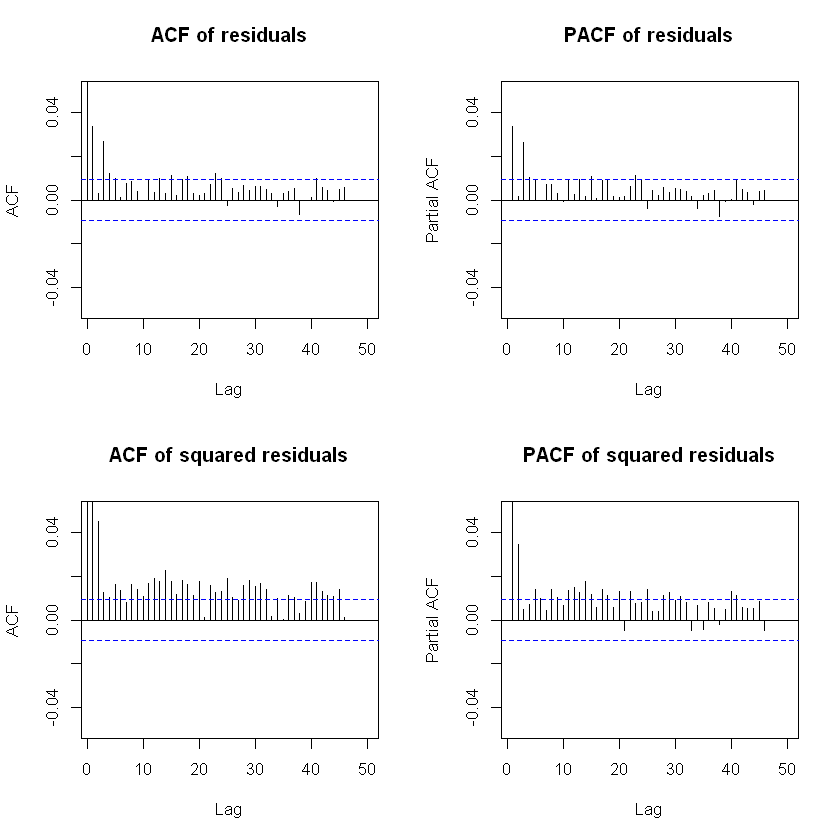

In [84]:
par(mfrow=c(2,2))
acf(residuals(model_fit_2), xlim=c(1,50), ylim=c(-0.05, 0.05), main='ACF of residuals')
pacf(residuals(model_fit_2), xlim=c(1,50), ylim=c(-0.05, 0.05), main='PACF of residuals')
acf(residuals(model_fit_2)^2, xlim=c(1,50), ylim=c(-0.05, 0.05), main='ACF of squared residuals')
pacf(residuals(model_fit_2)^2, xlim=c(1,50), ylim=c(-0.05, 0.05), main='PACF of squared residuals')

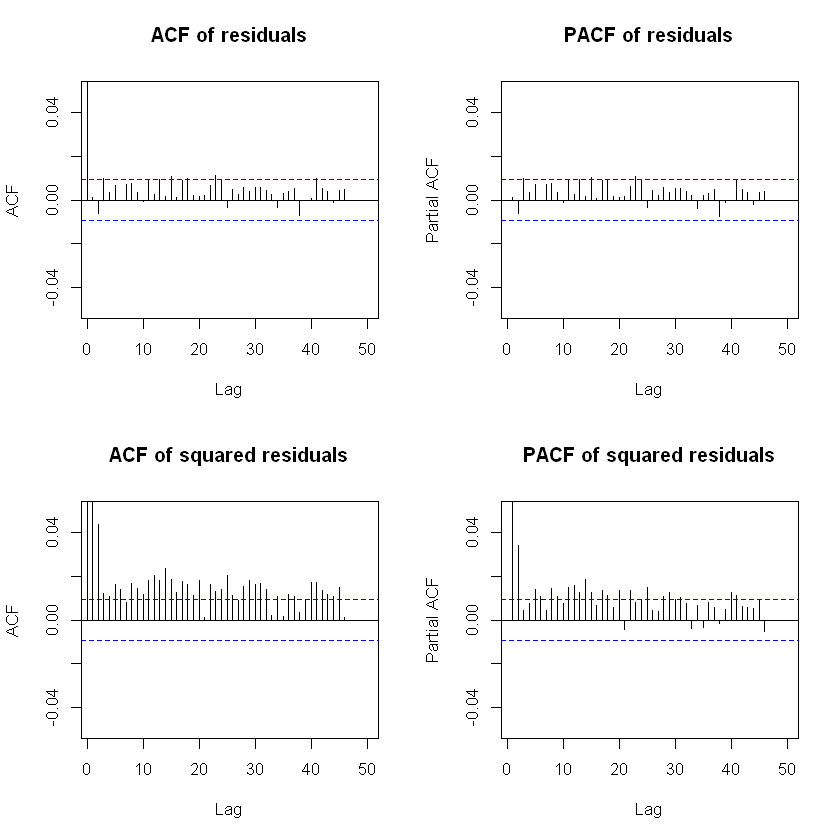

In [85]:
par(mfrow=c(2,2))
acf(residuals(model_fit_3), xlim=c(1,50), ylim=c(-0.05, 0.05), main='ACF of residuals')
pacf(residuals(model_fit_3), xlim=c(1,50), ylim=c(-0.05, 0.05), main='PACF of residuals')
acf(residuals(model_fit_3)^2, xlim=c(1,50), ylim=c(-0.05, 0.05), main='ACF of squared residuals')
pacf(residuals(model_fit_3)^2, xlim=c(1,50), ylim=c(-0.05, 0.05), main='PACF of squared residuals')

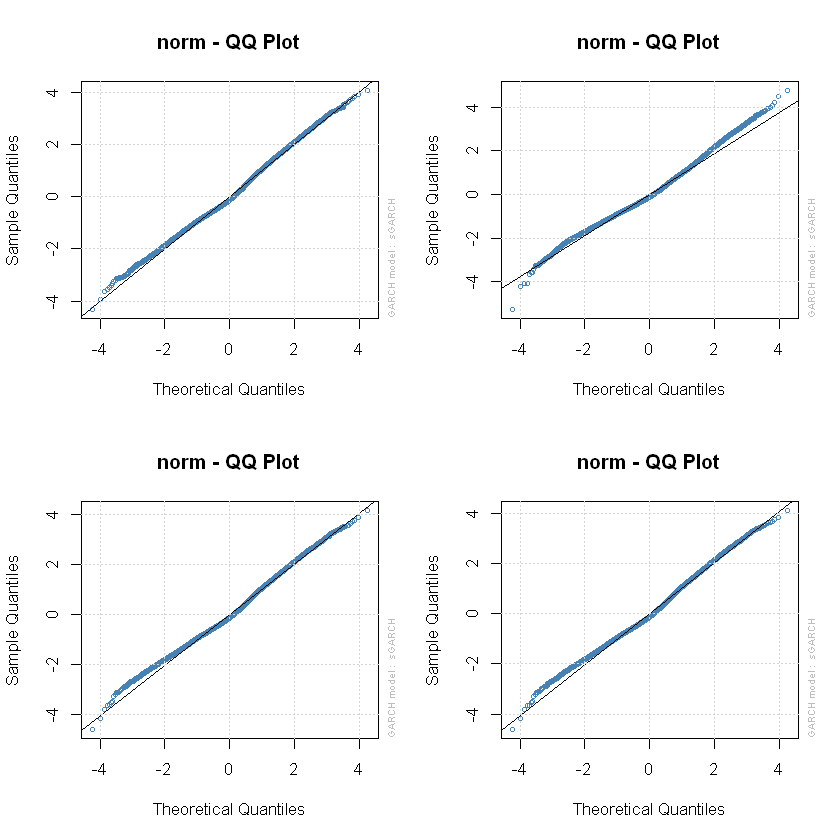

In [38]:
par(mfrow=c(2,2))
plot(model_fit_3, which = 9)
plot(model_fit_4, which = 9)
plot(model_fit_5, which = 9)
plot(model_fit_6, which = 9)

### Experiment with different distributions

In [107]:
garch_experiment_spec = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 
    1)), mean.model = list(armaOrder = c(2, 0), include.mean = TRUE), distribution.model = "sged")
model

garch_experiment_model = ugarchfit(spec = garch_experiment_spec, data = ts, solver = "hybrid")


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(2,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 
